<a href="https://colab.research.google.com/github/Motez1/Tweet_emotion_prediction/blob/master/Tweet_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing packages :


In [47]:
!pip install nlp

In [48]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16,6))

    plt.subplot(1,2,1)
    plt.plot(range(0,epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0,epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0.,1.])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(0,epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0,epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true,y_pred,normalize='true')

    plt.figure(figsize=(8,8))
    sp = plt.subplot(1,1,1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0,6)), labesl=classes)
    plt.yticks(list(range(0,6)), labesl=classes)
    plt.colorbar(ctx)
    plt.show()

print('Using TensorFlow version', tf.__version__)


Using TensorFlow version 2.6.0


# Importing Data : 

In [49]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [50]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [51]:
train = dataset["train"]
validation = dataset["validation"]
test = dataset["test"]

In [52]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [53]:
tweets , labels = get_tweet(train)

In [54]:
tweets[0] , labels[0] 

('i didnt feel humiliated', 'sadness')

#Tokenizer: 

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [56]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [57]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

#Padding and truncating sequences:
#####1.Check the lengths of sequences
#####2.Create padded sequences


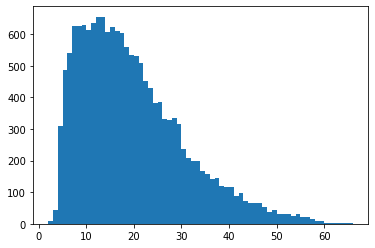

In [58]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [59]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [60]:
def gets_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding ='post',maxlen=maxlen)
  return padded

In [61]:
padded_train_seq = gets_sequences(tokenizer,tweets)

In [62]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

#Preparing the labels:
#####1.Create classes to index and index classes to dictionaries
#####2.Convert text labels to numeric labels

In [63]:
classes = set(labels)
print(classes)

{'joy', 'sadness', 'love', 'anger', 'surprise', 'fear'}


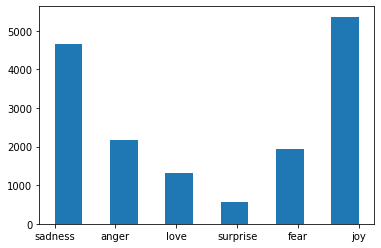

In [64]:
plt.hist(labels, bins = 11)
plt.show()

In [122]:
class_to_index = dict((cls,i) for i, cls in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())
index_to_class

{0: 'joy', 1: 'sadness', 2: 'love', 3: 'anger', 4: 'surprise', 5: 'fear'}

In [66]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [67]:
train_labels = names_to_ids(labels)
print(train_labels[0])

1


#Create the model:
#####1.Creating the model
#####2.Compiling the model

In [69]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')                    
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


#Train the model:
####1.Prepare a validation set
####2.Train the model



In [72]:
 val_tweets, val_labels = get_tweet(validation)
 val_seq = gets_sequences(tokenizer,val_tweets)
 val_labels = names_to_ids(val_labels)

In [75]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [76]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 39s 58ms/step - loss: 1.2717 - accuracy: 0.4973 - val_loss: 0.7612 - val_accuracy: 0.7395
Epoch 2/20
500/500 [==============================] - 27s 55ms/step - loss: 0.5174 - accuracy: 0.8269 - val_loss: 0.5535 - val_accuracy: 0.8160
Epoch 3/20
500/500 [==============================] - 27s 54ms/step - loss: 0.3500 - accuracy: 0.8820 - val_loss: 0.5285 - val_accuracy: 0.8175
Epoch 4/20
500/500 [==============================] - 28s 55ms/step - loss: 0.2684 - accuracy: 0.9051 - val_loss: 0.4765 - val_accuracy: 0.8290
Epoch 5/20
500/500 [==============================] - 27s 54ms/step - loss: 0.2025 - accuracy: 0.9321 - val_loss: 0.4354 - val_accuracy: 0.8600
Epoch 6/20
500/500 [==============================] - 27s 54ms/step - loss: 0.1668 - accuracy: 0.9486 - val_loss: 0.4633 - val_accuracy: 0.8650
Epoch 7/20
500/500 [==============================] - 27s 54ms/step - loss: 0.1262 - accuracy: 0.9612 - val_loss: 0.4534 - val_accuracy:

#Evaluate the model:
1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

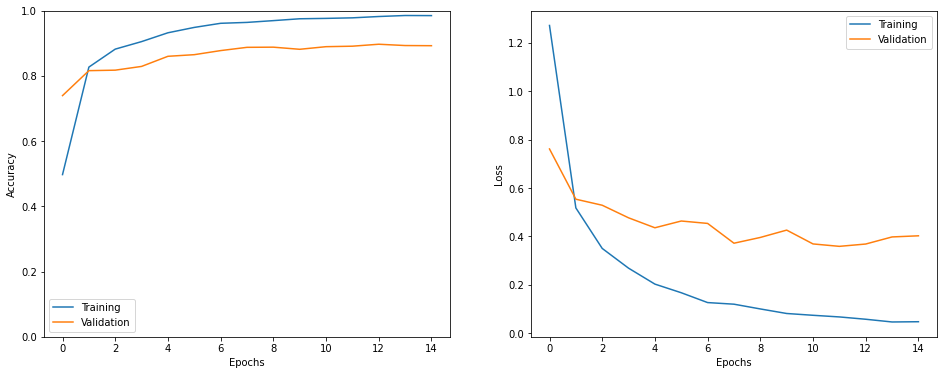

In [77]:
show_history(h)

In [80]:
test_tweets, test_labels = get_tweet(test)
test_sequences = gets_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [223]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 18ms/step - loss: 0.4573 - accuracy: 0.8905


In [259]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
p = model.predict(test_sequences)[i]
c = np.argmax(p,axis=0)
print("Predicted Emotion: ",index_to_class.get(c))

Sentence: i feel sure that i will go beyond that
Emotion: joy
Predicted Emotion:  joy
